<a href="https://colab.research.google.com/github/cedamusk/final-year/blob/main/finalyearproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install obspy tensorflow matplotlib

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime, Stream, Trace
from obspy.clients.fdsn import Client
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.filter import bandpass
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [9]:
def fetch_iris_data(network, station, location, channel, start_time, end_time):
  """
  Fetch seismic data from IRIS database
  """
  try:
    client=Client("IRIS")
    stream=client.get_waveforms(network, station, location, channel, start_time, end_time)
    return stream
  except Exception as e:
    print(f"Error fetching data from IRIS: {str(e)}")
    return None

In [10]:
def generate_synthetic_data(num_samples, sample_rate, event_duration, noise_level):
  """
  Generate synthetic seismic data for testing and validation
  """
  time=np.arange(num_samples)/sample_rate
  background=np.random.normal(0, noise_level, num_samples)

  #Create multiple events for more complex training
  num_events=np.random.randint(1,4)
  events=np.zeros(num_samples)
  event_locations=[]

  for _ in range(num_events):
    event_start=np.random.randint(num_samples // 8, num_samples * 7//8)
    event_end=event_start + int(event_duration *sample_rate)
    event_locations.append((event_start, event_end))

    #Create event with varying frequency and amplitude
    freq=np.random.uniform(3, 8)
    amp=np.random.uniform(0.8, 1.2)
    decay=np.random.uniform(0.1, 0.3)

    event=np.sin(2*np.pi*freq*(time[event_start:event_end]-time[event_start]))*\
          amp*np.exp(-(time[event_start:event_end]-time[event_start])/ decay)
    events[event_start:event_end]=event

  data =background +events
  return data, events, event_locations



In [20]:
def create_windows(data, window_size, step):
  """
  Create sliding windows for RNN input with overlap
  """
  windows=[]
  labels=[]

  for i in range(0, len(data)- window_size +1, step):
    window=data[i:i+window_size]

    #Add Feature engineering
    window_features=np.column_stack((
        window, #raw signal
        np.abs(window), #absolute amplitude
        np.gradient(window), #First deravitive
        np.gradient(np.gradient(window)) #Second derivative
    ))
    windows.append(window_features)

    if len(window)==window_size:
      labels.append(window.mean())
  return np.array(windows), np.array(labels)

In [12]:
def build_enhanced_rnn_model(input_shape):
  """
  Build an enhanced RNN model with multiple LSTM layers and additional features
  """
  model=Sequential([
      # First Bidirectional LSTM Layer
      Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
      BatchNormalization(),
      Dropout(0.3),

      #Second Bidirectional LSTM layer
      Bidirectional(LSTM(96, return_sequences=True)),
      BatchNormalization(),
      Dropout(0.3),

      #Third LSTM Layer
      LSTM(64),
      BatchNormalization(),
      Dropout(0.2),

      #Dense layer for classification
      Dense(32, activation='relu'),
      BatchNormalization(),
      Dropout(0.2),
      Dense(16, activation='relu'),
      Dense(1, activation='sigmoid')

  ])

  # Use Adam optimizer with custom learning rate
  optimizer=Adam(learning_rate=0.001)

  model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=['accuracy', 'Precision', 'Recall']
  )

  return model

In [13]:
def process_stream(stream, freqmin=0.5, freqmax=20):
  """
  Process a seismic stream with enhanced filtering
  """
  processed_stream=stream.copy()
  processed_stream.detrend('linear')
  processed_stream.taper(max_percentage=0.05)
  processed_stream.filter('bandpass', freqmin=freqmin, freqmax=freqmax,
                          corners=4, zerophase=True)
  return processed_stream

In [14]:
def evaluate_model(model, X_test, y_test, predictions):
  binary_predictions=(predictions>0.5).astype(int)

  accuracy=accuracy_score(y_test, binary_predictions)
  precision=precision_score(y_test, binary_predictions)
  recall=recall_score(y_test, binary_predictions)
  f1=f1_score(y_test, binary_predictions)

  report=classification_report(y_test, binary_predictions)

  cm=confusion_matrix(y_test, binary_predictions)

  print("\n===Model Performance Metrics===")
  print(f"Accuracy:{accuracy:.4f}")
  print(f"Precision:{precision:.4f}")
  print(f"Recall:{recall:.4f}")
  print(f"F1 Score:{f1:.4f}")

  print("\n=== Classification report===")
  print(report)

  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

  return accuracy, precision, recall, f1

In [23]:
def main(use_real_data=True):
  #Configuration parameters
  config={
      'window_size':200,
      'step':20,
      'sample_rate':100,
      'sta_length':50, #0.5 seconds
      'lta_length':500, #5 Seconds
      'threshold':1.5,
      'num_samples':20000
  }

  if use_real_data:
    #Fetch real data from IRIS
    end_time=UTCDateTime.now()
    start_time=end_time-3600

    stream=fetch_iris_data('YS', "BAOP", "", "BHZ", start_time, end_time)
    if stream is None:
      print("Falling back to synthetic data...")
      use_real_data=False
    else:
      filtered_stream=process_stream(stream)

  if not use_real_data:
    # Genearate synthetic data with multiple events
    synthetic_data, true_events, event_locations=generate_synthetic_data(
        config['num_samples'],
        config['sample_rate'],
        event_duration=2,
        noise_level=0.1
    )
    trace= Trace(data=synthetic_data)
    trace.stats.starttime=UTCDateTime("2021-01-01T00:00:00")
    trace.stats.delta=1.0/config['sample_rate']
    trace.stats.channel='SHZ'
    filtered_stream=Stream([trace])
    filtered_stream=process_stream(filtered_stream)

  #Create training data
  X, y=create_windows(
      filtered_stream[0].data,
      config['window_size'],
      config['step']
  )
  if use_real_data:
    #For real data, use STA/LTA triggers as initial labels
    triggers, sta_lta=sta_lta_detection(
        filtered_stream,
        config['sta_length'],
        config['lta_length'],
        config['threshold']
    )
    y=(y>config['threshold']).astype(int)
  else:
    y=(y>0).astype(int)

  print(f"X shape: {X.shape}")
  print(f"y shape: {y.shape}")

  #Prepare data for training
  X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

  #Normalize data
  mean=X_train.mean(axis=(0,1), keepdims=True)
  std=X_train.std(axis=(0,1), keepdims=True)
  X_train=(X_train -mean)/std
  X_test=(X_test-mean) /std

  #Build and train model
  input_shape=(config['window_size'], X.shape[2])
  model=build_enhanced_rnn_model(input_shape)

  #Add callbacks
  callbacks=[
      EarlyStopping(
          monitor='val_loss',
          patience=10,
          restore_best_weights=True
      ),
      ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.5,
          patience=5,
          min_lr=1e-6
      )
  ]
  #Train Model
  history=model.fit(
      X_train, y_train,
      epochs=100,
      batch_size=32,
      validation_split=0.2,
      callbacks=callbacks,
      verbose=1
  )

  # Make Predictions
  predictions=model.predict(X_test)
  accuracy, precision, recall, f1=evaluate_model(model, X_test, y_test, predictions)

  #plot results
  plot_results(filtered_stream, predictions, config, use_real_data, metrics={'accuracy':accuracy, 'precision': precision, 'recall':recall, 'f1':f1})
  plot_training_history(history)

In [16]:
def plot_results(stream, predictions, config, use_real_data, metrics=None):
  plt.figure(figsize=(15, 12))

  #Plot original data
  plt.subplot(3,1,1)
  plt.plot(stream[0].data, color='navy', linewidth=1.5)
  plt.title("Original Seismic Data", fontsize=12, fontweight='bold')
  plt.xlabel("Samples", fontsize=10)
  plt.ylabel("Amplitude", fontsize=10)

  if metrics:
    plt.text(0.02, 0.988,
             f"Accuracy: {metrics['accuracy']:.4f}\n"
             f"Precision: {metrics['precision']:.4f}\n"
             f"Recall: {metrics['recall']:.4f}\n"
             f"F1 Score:{metrics['f1']:.4f}",
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.subplot(3,1,2)
    plt.plot(predictions, color='green', linewidth=1.5, alpha=0.7)
    plt.title("Detection Prediction Probabilities", fontsize=12, fontweight='bold')
    plt.xlabel("Windows", fontsize=10)
    plt.ylabel("Probability", fontsize=10)
    plt.ylim(0,1)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(3,1,3)
    binary_preds=(predictions>0.5).astype(int)
    plt.plot(binary_preds, color='red', linewidth=1.5)
    plt.title("Binary Predictions(Threshold=0.5)", fontsize=12, fontweight='bold')
    plt.xlabel("Windows", fontsize=10)
    plt.ylabel("Detection", fontsize=10)
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



In [17]:
def plot_training_history(history):
  plt.figure(figsize=(15,5))

  plt.subplot(1,3,1)
  plt.plot(history.history['loss'], label="Training Loss", color='blue')
  plt.plot(history.history['val_loss'], label='Validatio loss', color='red')
  plt.title('Model Loss', fontsize=12, fontweight='bold')
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('loss', fontsize=10)
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.7)

  plt.subplot(1,3,2)
  plt.plot(history.history['accuracy'], label='Training accuracy', color='green')
  plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='orange')
  plt.title('Model Accuracy', fontsize=12, fontweight='bold')
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Accuracy', fontsize=10)
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.7)

  plt.subplot(1,3,3)
  plt.plot(history.history['Precision'], label='Precision', color='purple')
  plt.plot(history.history['Recall'], label='Recall', color='brown')
  plt.title('Precision and Recall', fontsize=12, fontweight='bold')
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Score', fontsize=10)
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.7)

  plt.tight_layout(pad=3.0)
  plt.show()

Error fetching data from IRIS: No data available for request.
HTTP Status code: 204
Detailed response of server:


Falling back to synthetic data...
X shape: (991, 200, 4)
y shape: (991,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - Precision: 0.6950 - Recall: 0.6135 - accuracy: 0.6516 - loss: 0.7230 - val_Precision: 0.5946 - val_Recall: 0.9167 - val_accuracy: 0.6331 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - Precision: 0.6908 - Recall: 0.6856 - accuracy: 0.6949 - loss: 0.6363 - val_Precision: 0.6593 - val_Recall: 0.8333 - val_accuracy: 0.6906 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - Precision: 0.7705 - Recall: 0.7467 - accuracy: 0.7441 - loss: 0.5429 - val_Precision: 1.0000 - val_Recall: 0.2222 - val_accuracy: 0.5971 - val_loss: 0.6546 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - Precision: 0.7359 - Recall: 0.7242 - accuracy: 0.7210 - loss: 0.5274 - val_Precision: 0.6161 - val_Recall: 0.9583 - val_accuracy: 0.6691 - val_loss: 0.6440 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - Precision: 0.70

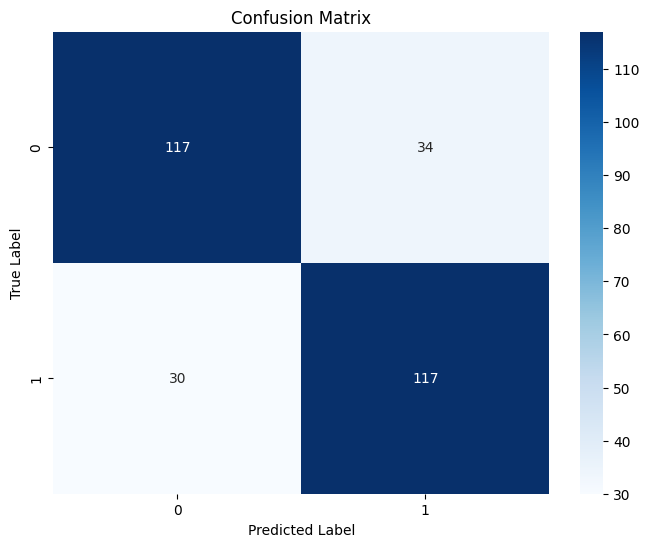

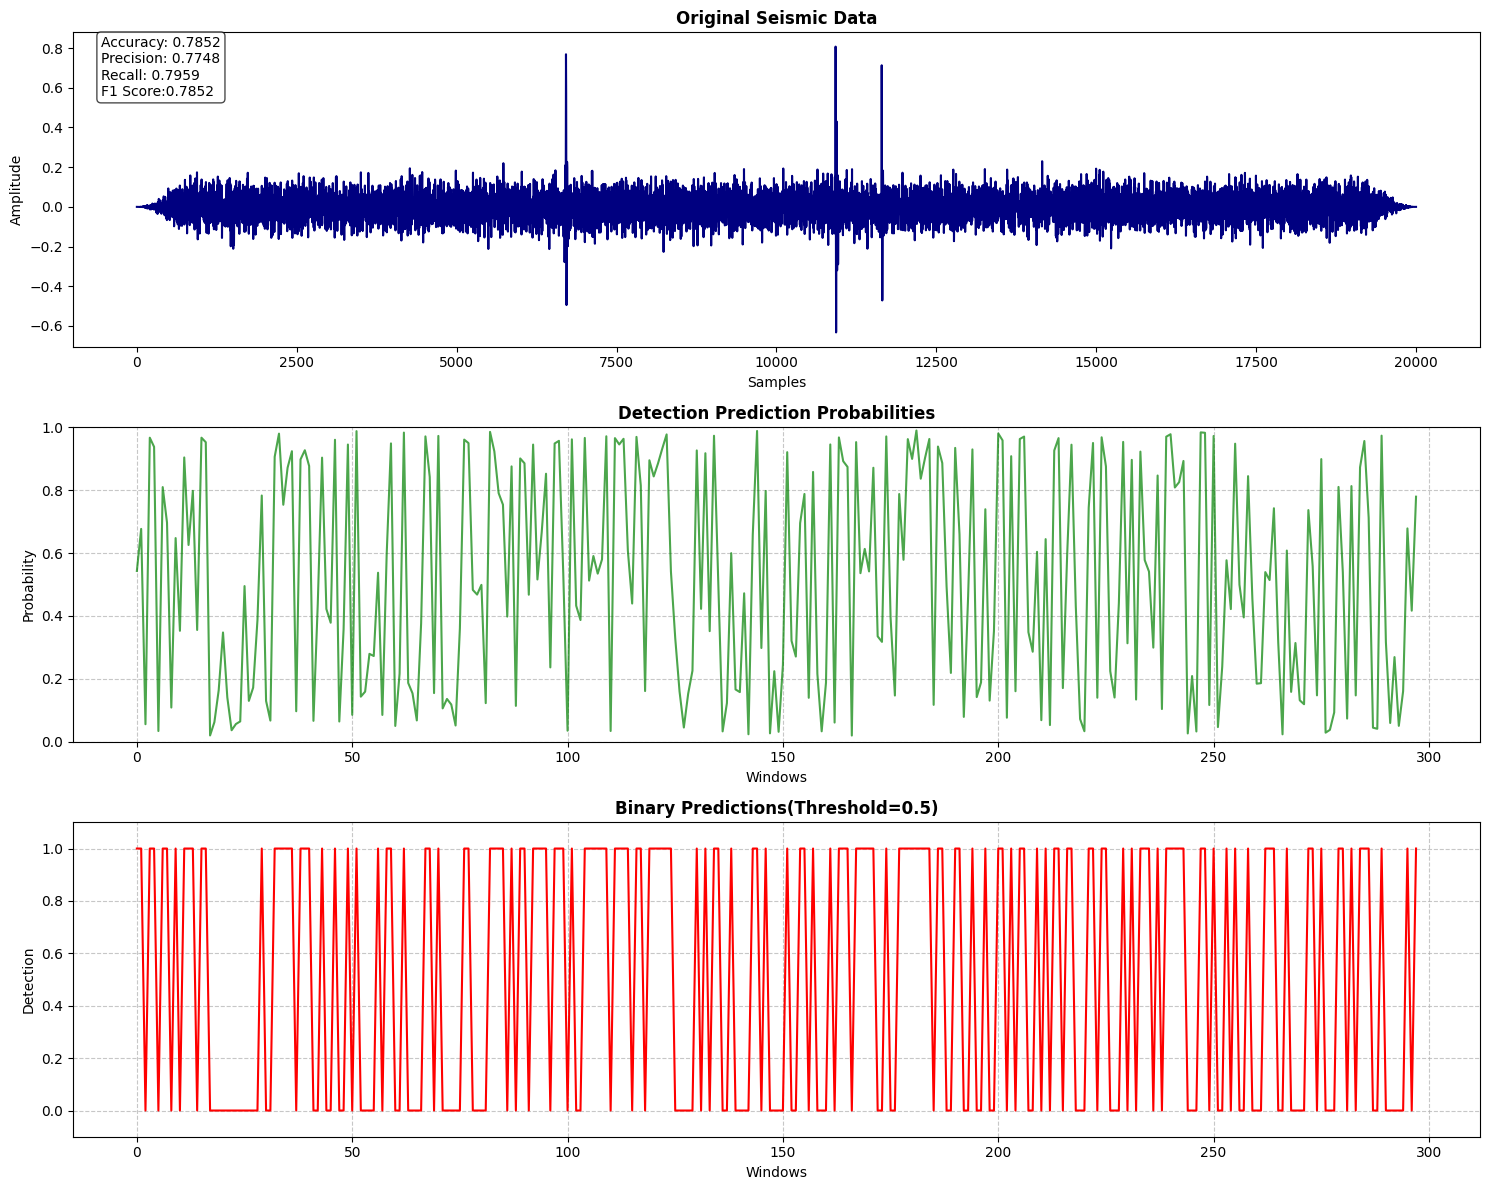

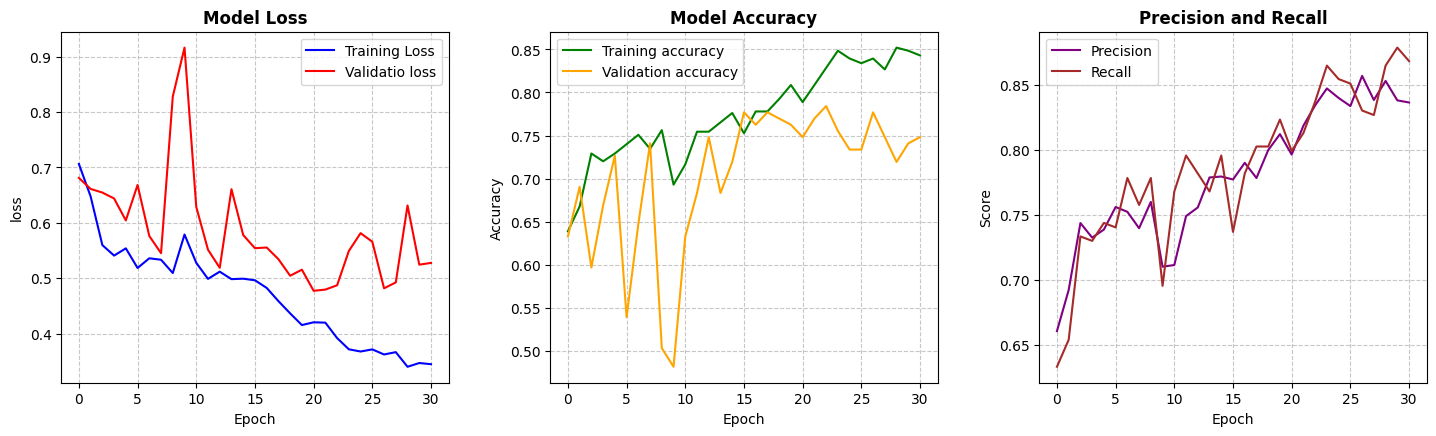

In [24]:
if __name__=="__main__":
  main(use_real_data=True)